In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

#import IPython.display as disp
from timm.data import Mixup
from timm.data.random_erasing import RandomErasing as RandomErasingTimm
from timm.loss import SoftTargetCrossEntropy
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_017"
EXP_NAME = f"{VERSION}_swin_base_patch4_window12"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); os.makedirs(MODEL_FOLDER, exist_ok=True)

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL  = "swin_base_patch4_window12_384_in22k"

NFOLDS = 5
BS = 32
SZ = 384

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

CROP_PCT = 1.0
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

In [4]:
all_df = pd.read_csv(CSV_PATH)

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [5]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [6]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [7]:
def get_dls(fold:int, bs:int, *args, **kwargs):
    
    item_tfms = [ToTensor, AlbumentationsTransform(TRAIN_AUG,VALID_AUG)]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

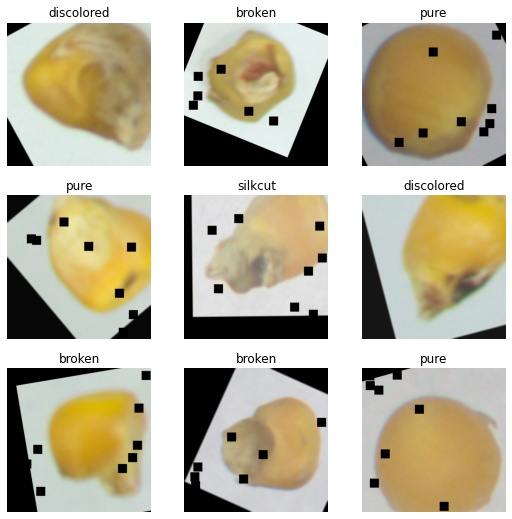

In [8]:
dls = get_dls(0, BS)
dls.show_batch()

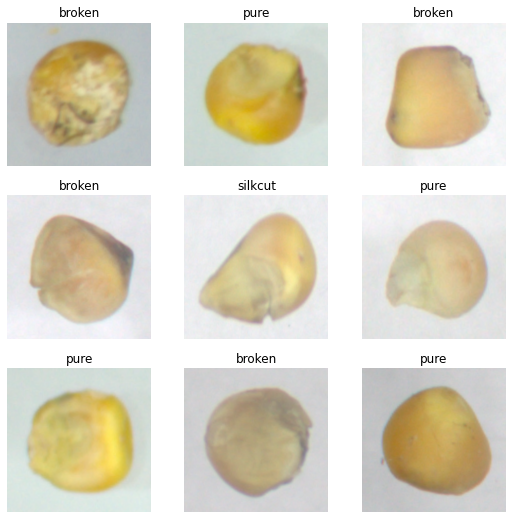

In [9]:
dls.valid.show_batch()

In [10]:
def build_experiment(fold:int = 0, pretrained:bool=True):
    print(f'model:{TIMM_MODEL}; pretrained:{pretrained}')
    print(f'fold:{fold}; sz:{SZ}; bs:{BS}')
    
    dls = get_dls(fold, bs=BS)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=pretrained,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    return dls, learn


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:swin_base_patch4_window12_384_in22k; pretrained:True
fold:0; sz:384; bs:32


SuggestedLRs(valley=0.002511886414140463, slide=0.002511886414140463)
CPU: 1615/125/3283 MB | GPU: 1058/16806/2583 MB | Time 0:00:38.661 | (Consumed/Peaked/Used Total)


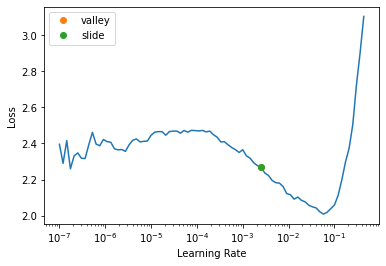

In [14]:
set_seed(42); set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
    dls, learn = build_experiment(0)
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [17]:
n_epo = 15; base_lr = 0.003;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup_ft"

In [22]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f'epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   MixUp(0.4),
                   WandbCallback(log_preds=None)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 0
****************************************************************************************************
model:swin_base_patch4_window12_384_in22k; pretrained:True
fold:0; sz:384; bs:32
epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.150455,0.932197,0.651658,02:36


Better model found at epoch 0 with accuracy value: 0.6516579389572144.


epoch,train_loss,valid_loss,accuracy,time
0,0.953970,0.643233,0.744503,03:11
1,0.861920,0.611523,0.752880,03:11
2,0.838395,0.622486,0.752531,03:11
3,0.826338,0.587692,0.771379,03:11
4,0.791434,0.566070,0.780454,03:11
5,0.781665,0.527151,0.796859,03:11
6,0.721590,0.532568,0.789878,03:11
7,0.717377,0.506426,0.806981,03:11
8,0.721380,0.491040,0.810471,03:11
9,0.683547,0.494536,0.806283,03:11


Better model found at epoch 0 with accuracy value: 0.744502604007721.
Better model found at epoch 1 with accuracy value: 0.7528795599937439.
Better model found at epoch 3 with accuracy value: 0.7713786959648132.
Better model found at epoch 4 with accuracy value: 0.7804537415504456.
Better model found at epoch 5 with accuracy value: 0.7968586683273315.
Better model found at epoch 7 with accuracy value: 0.8069807887077332.
Better model found at epoch 8 with accuracy value: 0.8104711771011353.
Better model found at epoch 11 with accuracy value: 0.8143106698989868.
Better model found at epoch 13 with accuracy value: 0.8150086998939514.
CPU: 520/226/3759 MB | GPU: 6426/15036/9010 MB | Time 0:51:00.113 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 1
****************************************************************************************************
model:swin_base_patch4_window12_384_in22k; pretrained:True
fold:1; sz:384; bs:32
epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.158912,0.751258,0.695637,02:38


Better model found at epoch 0 with accuracy value: 0.6956369876861572.


epoch,train_loss,valid_loss,accuracy,time
0,0.932896,0.640542,0.740663,03:11
1,0.857433,0.575456,0.764747,03:11
2,0.831123,0.559864,0.771728,03:12
3,0.804380,0.536644,0.778709,03:11
4,0.790579,0.609399,0.768237,03:11
5,0.761501,0.509710,0.801745,03:12
6,0.738039,0.493509,0.808726,03:12
7,0.715553,0.509553,0.803839,03:11
8,0.736180,0.490518,0.805934,03:12
9,0.696774,0.508916,0.800698,03:12


Better model found at epoch 0 with accuracy value: 0.7406631708145142.
Better model found at epoch 1 with accuracy value: 0.7647469639778137.
Better model found at epoch 2 with accuracy value: 0.7717277407646179.
Better model found at epoch 3 with accuracy value: 0.7787085771560669.
Better model found at epoch 5 with accuracy value: 0.8017451763153076.
Better model found at epoch 6 with accuracy value: 0.8087260127067566.
Better model found at epoch 10 with accuracy value: 0.8157067894935608.
Better model found at epoch 11 with accuracy value: 0.8167539238929749.
Better model found at epoch 12 with accuracy value: 0.8178010582923889.
Better model found at epoch 13 with accuracy value: 0.8195462226867676.
CPU: 98/352/3857 MB | GPU: 942/14408/9952 MB | Time 0:51:02.086 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************
model:swin_base_patch4_window12_384_in22k; pretrained:True
fold:2; sz:384; bs:32
epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.175125,0.848416,0.659218,02:38


Better model found at epoch 0 with accuracy value: 0.659217894077301.


epoch,train_loss,valid_loss,accuracy,time
0,0.934063,0.650994,0.734986,03:12
1,0.856828,0.617638,0.749651,03:12
2,0.820290,0.585229,0.770251,03:12
3,0.790798,0.578758,0.766760,03:12
4,0.791407,0.573404,0.774441,03:12
5,0.771598,0.541987,0.788408,03:12
6,0.723358,0.543116,0.784916,03:12
7,0.728691,0.531778,0.789455,03:12
8,0.710998,0.510691,0.799581,03:12
9,0.702069,0.501492,0.803073,03:12


Better model found at epoch 0 with accuracy value: 0.7349860072135925.
Better model found at epoch 1 with accuracy value: 0.7496508359909058.
Better model found at epoch 2 with accuracy value: 0.7702513933181763.
Better model found at epoch 4 with accuracy value: 0.7744413614273071.
Better model found at epoch 5 with accuracy value: 0.7884078025817871.
Better model found at epoch 7 with accuracy value: 0.7894552946090698.
Better model found at epoch 8 with accuracy value: 0.799580991268158.
Better model found at epoch 9 with accuracy value: 0.8030726313591003.
Better model found at epoch 10 with accuracy value: 0.8037709593772888.
Better model found at epoch 11 with accuracy value: 0.8051676154136658.
Better model found at epoch 12 with accuracy value: 0.8076117038726807.
Better model found at epoch 13 with accuracy value: 0.811103343963623.
CPU: 33/308/3890 MB | GPU: 2366/11850/12318 MB | Time 0:51:07.810 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend



****************************************************************************************************
Training fold 3
****************************************************************************************************
model:swin_base_patch4_window12_384_in22k; pretrained:True
fold:3; sz:384; bs:32
epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.169266,0.920228,0.626397,02:38


Better model found at epoch 0 with accuracy value: 0.626396656036377.


epoch,train_loss,valid_loss,accuracy,time
0,0.919314,0.643023,0.735684,03:11
1,0.892540,0.575745,0.766411,03:12


Better model found at epoch 0 with accuracy value: 0.735684335231781.
Better model found at epoch 1 with accuracy value: 0.7664105892181396.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 8 with accuracy value: 0.8083100318908691.
Better model found at epoch 9 with accuracy value: 0.8107541799545288.
Better model found at epoch 10 with accuracy value: 0.8118016719818115.
Better model found at epoch 11 with accuracy value: 0.8149441480636597.
Better model found at epoch 12 with accuracy value: 0.8187848925590515.
CPU: -35/303/3840 MB | GPU: 1678/11718/12494 MB | Time 0:51:07.643 | (Consumed/Peaked/Used Total)


In [23]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:swin_base_patch4_window12_384_in22k; pretrained:False
fold:0; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_017_swin_base_patch4_window12_384_bs32_epo15_mixup_ft_CV_00' (00)


* Accuracy : 0.8181501030921936

model:swin_base_patch4_window12_384_in22k; pretrained:False
fold:1; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_017_swin_base_patch4_window12_384_bs32_epo15_mixup_ft_CV_01' (01)


* Accuracy : 0.8164048790931702

model:swin_base_patch4_window12_384_in22k; pretrained:False
fold:2; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_017_swin_base_patch4_window12_384_bs32_epo15_mixup_ft_CV_02' (02)


* Accuracy : 0.8114525079727173

model:swin_base_patch4_window12_384_in22k; pretrained:False
fold:3; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_017_swin_base_patch4_window12_384_bs32_epo15_mixup_ft_CV_03' (03)


* Accuracy : 0.8226256966590881

model:swin_base_patch4_window12_384_in22k; pretrained:False
fold:4; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_017_swin_base_patch4_window12_384_bs32_epo15_mixup_ft_CV_04' (04)


* Accuracy : 0.8219273686408997

CPU: 379/13/4219 MB | GPU: -9154/1438/3340 MB | Time 0:05:32.548 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.81815, 0.8164, 0.81145, 0.82263, 0.82193]
Avg: 0.81811
Std: 0.00405
